# Topic modelling

In this notebook, we perform a topic modelling analysis of COVID-19 publications.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, pickle
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [2]:
df_meta = pd.read_csv("../cwts_covid/datasets_output/df_pub.csv",compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")

In [3]:
import re

def clean_year(s):
    if pd.isna(s):
        return np.nan
    if not (s>1900):
        return np.nan
    elif s>2020:
        return 2020
    return s

df_meta["publication_year"] = df_meta["publication_year"].apply(clean_year)

In [4]:
df_meta.publication_year.describe()

count    61467.000000
mean      2012.434851
std          8.671299
min       1951.000000
25%       2009.000000
50%       2015.000000
75%       2020.000000
max       2020.000000
Name: publication_year, dtype: float64

In [5]:
df_meta.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,timestamp
0,0,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020.0,NaN,Science,NaN,NaN,NaN,0.1126/science.abb7331,NaN,NaN,NaN,2020-04-18 09:20:24.986698
1,1,[Ten hot issues of breast cancer under the nov...,NaN,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,32036640.0,NaN,pub.1124777091,2020-04-18 09:20:24.986698
2,2,Another Piece of the Puzzle: Human Metapneumov...,BACKGROUND: Each winter respiratory viruses ac...,2008.0,12.0,Archives of Internal Medicine,NaN,NaN,NaN,10.1001/archinte.168.22.2489,19064834.0,pmc2783624,NaN,2020-04-18 09:20:24.986698
3,3,Viral etiology of severe pneumonia among Kenya...,CONTEXT: Pneumonia is the leading cause of chi...,2010.0,5.0,JAMA,NaN,NaN,NaN,10.1001/jama.2010.675,20501927.0,pmc2968755,NaN,2020-04-18 09:20:24.986698
4,4,Critically Ill Patients With Influenza A(H1N1)...,NaN,2014.0,4.0,JAMA,NaN,NaN,NaN,10.1001/jama.2014.2116,24566924.0,pmc6689404,NaN,2020-04-18 09:20:24.986698


In [6]:
df_meta.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'timestamp'],
      dtype='object')

## Text analysis

In [7]:
# TODO: add a language detection to remove all non-English

In [8]:
df_meta[df_meta["abstract"]==""].shape

(0, 14)

In [9]:
# concatenate abstracts and titles

# note that ~13k articles have no abstract
df_meta["title"] = df_meta["title"].fillna('')
df_meta["abstract"] = df_meta["abstract"].fillna('')
df_meta["title_abstract"] = df_meta.title +" "+df_meta.abstract

In [10]:
#texts = df_cord19[(pd.notnull(df_cord19["title_abstract"])) & (df_cord19.publication_year>2019)].title_abstract.tolist()
texts = df_meta[(pd.notnull(df_meta["title_abstract"]))].title_abstract.tolist()
texts[0]

'‘A ticking time bomb’: Scientists worry about coronavirus spread in Africa CAPE TOWN, SOUTH AFRICA—Late on Sunday evening, South African President Cyril Ramaphosa, in a televised address to the nation, declared that COVID-19, the respiratory disease spreading globally, had become a “national disaster.” The declaration allows his government to access special funding and instigate harsh regulations to combat the viral outbreak. “Never before in the history of our democracy have we been confronted by such a severe situation,” Ramaphosa said before announcing a raft of measures to curb the virus’ spread, including school closures, travel restrictions, and bans on large gatherings. So far, the official numbers seemed to suggest that sub-Saharan Africa, home to more than 1 billion people, had been lucky. The interactive map of reported COVID-19 cases run by Johns Hopkins University shows big red blobs almost everywhere—except sub-Saharan Africa.'

In [11]:
df_meta.shape

(61482, 15)

In [12]:
len(texts)

61482

#### Topic modelling

In [13]:
from tqdm import tqdm
import gensim, sklearn
import scispacy
import spacy
import pyLDAvis.gensim

In [ ]:
!python -m spacy download en

In [30]:
#nlp = spacy.load('en')
nlp = spacy.load("en_core_sci_md")
#STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

In [32]:
%%time

# pre-processing: use lemmas and remove stopwords, add entities

processed_docs = list()
for doc in nlp.pipe(texts, n_process=6, batch_size=100):

    ents = doc.ents  # Named entities

    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and len(token) > 1]# token.is_alpha]

    # Add named entities, but only if they are a compound of more than one word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
                        
    processed_docs.append(doc)

CPU times: user 6min 6s, sys: 26.8 s, total: 6min 33s
Wall time: 7min 33s


In [33]:
import pickle

pickle.dump(processed_docs, open("data/processed_docs_scispacy_2.pk", "wb"))

In [14]:
import pickle

processed_docs = pickle.load(open("data/processed_docs_scispacy_2.pk", "rb"))

In [34]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear several times or more). A better approach would be to use a chi_sq test.
bigram = Phrases(docs, min_count=100)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [35]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
# Admittedly, values are arbitrary here.
max_freq = 0.5
min_wordcount = 10

In [36]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of docs: %d (%d)' % (len(corpus),len(texts)))

Number of unique tokens: 32272
Number of docs: 61482 (61482)


In [37]:
dictionary.token2id["covid-19"]

20

In [38]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 10, 'random_state': seed}
model = LdaModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 6min 41s, sys: 3.12 s, total: 6min 44s
Wall time: 7min 32s


In [39]:
model.show_topics(num_words=10, num_topics=params['num_topics'])

[(0,
  '0.024*"health" + 0.015*"disease" + 0.014*"public" + 0.011*"pandemic" + 0.010*"outbreak" + 0.009*"country" + 0.009*"public_health" + 0.007*"Health" + 0.006*"global" + 0.006*"infectious"'),
 (1,
  '0.041*"cell" + 0.037*"virus" + 0.026*"viral" + 0.021*"infection" + 0.014*"replication" + 0.013*"host" + 0.013*"protein" + 0.012*"gene" + 0.011*"expression" + 0.009*"antiviral"'),
 (2,
  '0.039*"cell" + 0.028*"mouse" + 0.014*"response" + 0.011*"immune" + 0.010*"expression" + 0.009*"infection" + 0.008*"disease" + 0.007*"cytokine" + 0.007*"increase" + 0.007*"level"'),
 (3,
  '0.036*"covid-19" + 0.032*"patient" + 0.027*"case" + 0.023*"COVID-19" + 0.019*"coronavirus" + 0.015*"China" + 0.013*"sars-cov-2" + 0.012*"2019" + 0.011*"2020" + 0.009*"severe"'),
 (4,
  '0.038*"virus" + 0.017*"strain" + 0.013*"calf" + 0.011*"isolate" + 0.011*"human" + 0.009*"diarrhea" + 0.008*"animal" + 0.008*"pig" + 0.008*"bat" + 0.008*"study"'),
 (5,
  '0.036*"protein" + 0.015*"activity" + 0.014*"membrane" + 0.011*"

In [40]:
# printout for LaTeX
#for t in model.show_topics(num_words=20, num_topics=params['num_topics'], formatted=False):
#    print("\\item \\textbf{Topic #%d}"%t[0]+": "+"``"+"'', ``".join([w[0] for w in t[1] if len(w[0])>2])+"''.")

In [41]:
# plot topics (NOTE: the IDs here do not match those from the model)
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [42]:
# topics over time

df_local = df_meta[pd.notnull(df_meta["title_abstract"])]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
topics = np.zeros((len(docs),params['num_topics']))

for n,doc_topics in enumerate(model.get_document_topics(corpus)):
    for t in doc_topics:
        topics[n][t[0]] = t[1]

In [43]:
topics[0,:]

array([0.47294521, 0.        , 0.        , 0.20065041, 0.05454718,
       0.01885544, 0.14043811, 0.        , 0.        , 0.10556974,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [44]:
model.get_document_topics(corpus[0])

[(0, 0.47293168),
 (3, 0.20065248),
 (4, 0.0545542),
 (5, 0.018853175),
 (6, 0.14044547),
 (9, 0.10556908)]

In [45]:
df_topics = pd.DataFrame(topics)

In [46]:
df_topics["year"] = publication_years
df_topics["doi"] = dois

In [47]:
from_which_year = 1980

grouped = df_topics.groupby('year')
#grouped = df_topics[df_topics.isin({'doi': clusters[3]})["doi"]].groupby('year')
df_grouped = grouped.aggregate(np.mean)
df_grouped = df_grouped[df_grouped.index >= from_which_year]
#df_grouped

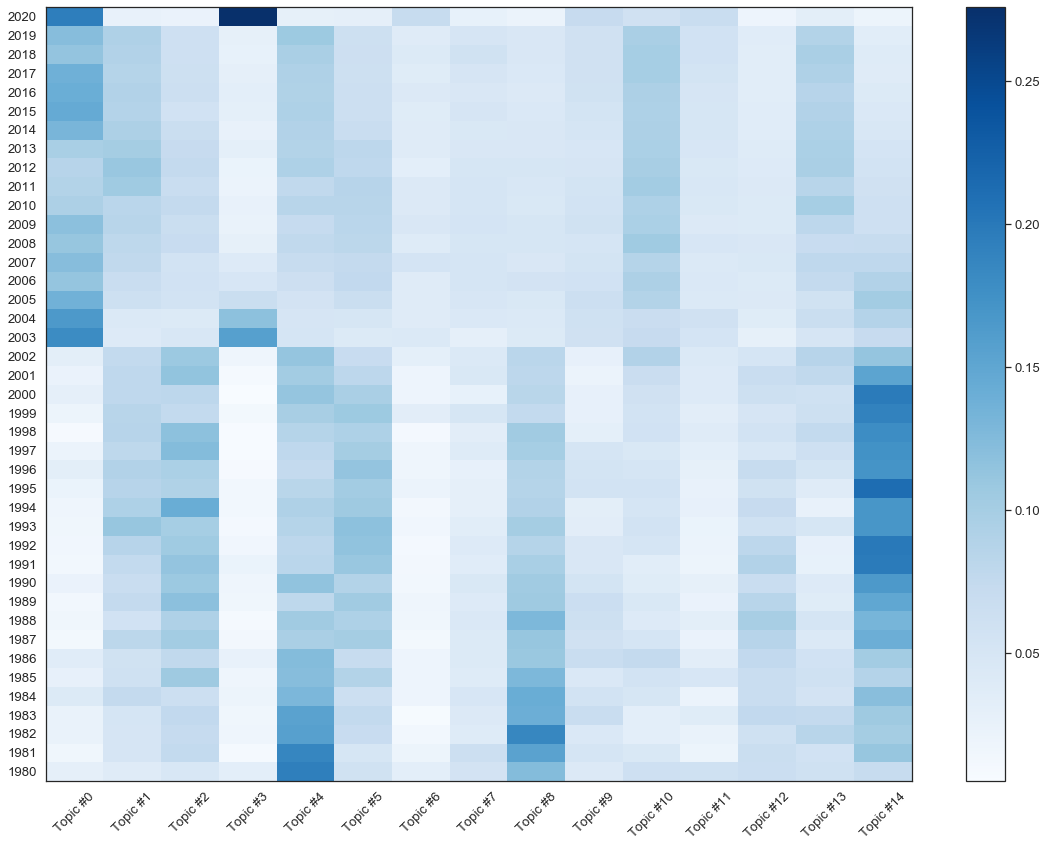

In [95]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped.index.values])
plt.xticks(np.arange(df_grouped.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(model.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_all_time_15.pdf")
plt.show()

#### Macrotopic analysis

In [66]:
# define macro topics

topic_labels = {
    "Coronavirus outbreaks": [3],
    "Public health": [0,11],
    "Epidemics": [6,9],
    "Animal transmission": [4,8],
    "Molecular biology": [1,2,14],
    "Respiratory diseases": [13],
    "Immunology": [5,12],
    "Systematic reviews": [10],
    "Diagnosing": [7]
}

In [67]:
# get number of papers per macro topic over time

is_selected_topic = {t:[0 for _ in range(len(docs))] for t in topic_labels.keys()}
topic_to_label = dict()
for k,v in topic_labels.items():
    for vv in v:
        topic_to_label[vv] = k
for d in range(len(docs)):
    d_topics = model.get_document_topics(corpus[d])
    for x in d_topics:
        is_selected_topic[topic_to_label[x[0]]][d] += x[1]

In [81]:
# plot trends

df_topic_intensity = pd.DataFrame.from_dict(is_selected_topic)
df_topic_intensity["year"] = publication_years
df_topic_intensity["doi"] = dois
df_topic_intensity["pub_id"] = df_meta.pub_id.to_list()
df_topic_intensity["title"] = df_meta.title.to_list()

In [93]:
from_which_year = 2000

grouped_ti = df_topic_intensity.groupby('year')
df_grouped_ti = grouped_ti.aggregate(np.mean)
#df_grouped_ti = grouped_ti.aggregate(np.sum)
df_grouped_ti = df_grouped_ti[df_grouped_ti.index >= from_which_year]

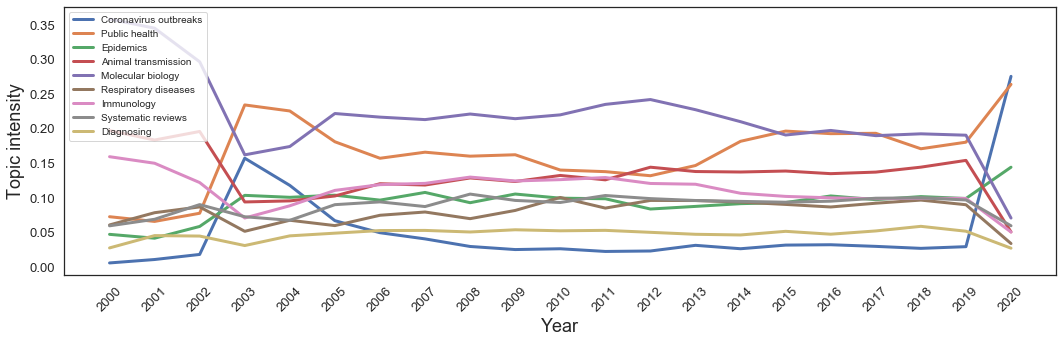

In [94]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():#["Coronavirus","Public health and epidemics","Molecular biology","Influenza","Immunology"]:
    plt.plot(df_grouped_ti[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti.shape[0]), [int(x) for x in df_grouped_ti.index.values], rotation=45)
plt.legend(loc="upper left",fontsize=10)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_trends_mean.pdf")

In [91]:
# does it work?

df_topic_intensity.sort_values("Systematic reviews", ascending=False).head()

,Coronavirus outbreaks,Public health,Epidemics,Animal transmission,Molecular biology,Respiratory diseases,Immunology,Systematic reviews,Diagnosing,year,doi,pub_id,title
27935,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.941652,0.0,1995.0,10.1038/nm0895-742,27935,Genomic prospecting
52977,0.0,0.046749,0.0,0.0,0.000000,0.0,0.000000,0.936237,0.0,2019.0,10.3390/biom9080344,52977,Tannins: Prospectives and Actual Industrial Ap...
5149,0.0,0.000000,0.0,0.0,0.019443,0.0,0.034272,0.933355,0.0,2009.0,10.1007/s11427-009-0006-7,5149,Current research status of immunology in the g...
14077,0.0,0.000000,0.0,0.0,0.065243,0.0,0.038071,0.884512,0.0,2009.0,10.1016/j.drudis.2009.04.001,14077,Immunoinformatics: Current trends and future d...
12728,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.883316,0.0,2008.0,10.1016/j.cbpa.2008.02.016,12728,Proteomics and genomics: perspectives on drug ...


In [79]:
# save data frame

df_topic_intensity.drop(columns=["title"], inplace=True)
df_topic_intensity.to_csv("data/df_topic_intensity.csv", compression="gzip", index=False)

### Support sections

##### Number of topics

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.
    From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    params = {'passes': 3, 'random_state': seed}
    for num_topics in range(start, limit, step):
        m = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,# workers=6,
                passes=params['passes'], random_state=params['random_state'])
        model_list.append(m)
        coherencemodel = CoherenceModel(model=m, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run
limit=50; start=5; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)])
plt.xticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins